# Xử lý dữ liệu

In [1]:
import pandas as pd

def convert_units(df, factor, start_col):
    # Xác định vị trí của cột bắt đầu chuyển đổi
    start_idx = df.columns.get_loc(start_col) + 1  # Cột tiếp theo sau start_col
    numeric_cols = df.columns[start_idx:]  # Chỉ lấy các cột từ vị trí này trở đi

    # Chỉ nhân hệ số với các cột số từ vị trí start_col trở đi
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce') / factor
    return df

# Đọc dữ liệu từ các file Excel
df1 = pd.read_excel("2020-Vietnam.xlsx", engine="openpyxl")
df2 = pd.read_excel("2021-Vietnam.xlsx", engine="openpyxl")
df3 = pd.read_excel("2022-Vietnam.xlsx", engine="openpyxl")
df4 = pd.read_excel("2023-Vietnam.xlsx", engine="openpyxl")
df5 = pd.read_excel("2024-Vietnam.xlsx", engine="openpyxl")

# Xóa năm khỏi tên cột
for df, year in zip([df1, df2, df3, df4, df5], range(2020, 2025)):
    df.columns = df.columns.str.replace(f"Năm: {year}", "", regex=True).str.strip()

# Xóa đơn vị tiền tệ khỏi tên cột
for df in [df1, df2, df3, df4, df5]:
    df.columns = df.columns.str.replace(r"Đơn vị: (Tỷ|Triệu) VND", "", regex=True).str.strip()

# Xóa cụm "Hợp nhất" và "Hàng năm" khỏi tên cột
for df in [df1, df2, df3, df4, df5]:
    df.columns = df.columns.str.replace(r"\bHợp nhất\b", "", regex=True).str.strip()
    df.columns = df.columns.str.replace(r"\bQuý: Hàng năm\b", "", regex=True).str.strip()

# Xóa các cột có chứa cụm "TM" trong tên
for df in [df1, df2, df3, df4, df5]:
    df.drop(columns=[col for col in df.columns if "TM" in col], inplace=True)

# Xác định tên cột tham chiếu
start_column = "Trạng thái kiểm toán"

# Chuẩn hóa tên cột start_column trước khi sử dụng
start_column_cleaned = start_column.replace("Hợp nhất", "").replace("Hàng năm", "").strip()

# Chuyển đổi đơn vị của tất cả DataFrame từ df1 đến df3
df1 = convert_units(df1, 1e9, start_column_cleaned)
df2 = convert_units(df2, 1e9, start_column_cleaned)
df3 = convert_units(df3, 1e9, start_column_cleaned)

# Tạo dataframe

In [2]:
import pandas as pd

def standardize_columns(df):
    df = df.copy()
    df.columns = df.columns.str.strip()  # Xóa khoảng trắng đầu/cuối tên cột
    df.columns = df.columns.str.replace("\n", " ")  # Thay ký tự xuống dòng bằng khoảng trắng
    df.columns = df.columns.str.upper()  # Chuyển tất cả tên cột thành chữ hoa để đồng nhất
    return df

def merge_balance_sheets(dfs, stock_code):
    data = []
    years = list(range(2020, 2025))
    
    dfs = [standardize_columns(df) for df in dfs]  # Chuẩn hóa tất cả DataFrame trước khi xử lý
    
    for df, year in zip(dfs, years):        
        if 'MÃ' not in df.columns:
            print(f"LỖI: Cột 'MÃ' không tồn tại trong file năm {year}")
            continue
        
        stock_data = df[df['MÃ'] == stock_code]
        if not stock_data.empty:
            data.append(stock_data)
    
    if data:
        result_df = pd.concat(data, ignore_index=True)
        return result_df
    else:
        return pd.DataFrame()  

# Danh sách DataFrame đã xử lý từ các file Excel
dfs = [df1, df2, df3, df4, df5]

# Nhập mã cổ phiếu từ người dùng
stock_code = input("Nhập mã cổ phiếu: ")

# Gộp dữ liệu
merged_df = merge_balance_sheets(dfs, stock_code)
merged_df = merged_df.loc[:, ~merged_df.columns.str.contains("CURRENT RATIO", case=False)]
merged_df

# Chuyển đổi DataFrame từ 5 hàng × 167 cột thành 5 cột × 167 hàng
transposed_df = merged_df.T  # Chuyển vị DataFrame
transposed_df.columns = [f"{year}" for year in range(2020, 2025)]  # Đặt tên cột theo năm
transposed_df.reset_index(inplace=True)  # Chuyển chỉ mục thành cột
transposed_df.rename(columns={"index": "Chỉ tiêu"}, inplace=True)  # Đặt tên cột cho chỉ mục

# Thay thế NaN bằng 0
transposed_df = transposed_df.fillna(0)  

# In kết quả
transposed_df


Nhập mã cổ phiếu:  GAS


,Chỉ tiêu,2020,2021,2022,2023,2024
0,MÃ,GAS,GAS,GAS,GAS,GAS
1,TÊN CÔNG TY,PV Gas,PV Gas,PV Gas,PV Gas,PV Gas
2,SÀN,HOSE,HOSE,HOSE,HOSE,HOSE
3,NGÀNH ICB - CẤP 1,Tiện ích Cộng đồng,Tiện ích Cộng đồng,Tiện ích Cộng đồng,Tiện ích Cộng đồng,Tiện ích Cộng đồng
4,NGÀNH ICB - CẤP 2,"Điện, nước & xăng dầu khí đốt","Điện, nước & xăng dầu khí đốt","Điện, nước & xăng dầu khí đốt","Điện, nước & xăng dầu khí đốt","Điện, nước & xăng dầu khí đốt"
...,...,...,...,...,...,...
90,LCTT. TIỀN VÀ TƯƠNG ĐƯƠNG TIỀN CUỐI KỲ (TT),5237.246729,5300.330735,10549.337639,5668.895193,5649.483431
91,LCTT. ĐẦU TƯ VÀO DOANH NGHIỆP KHÁC,0.0,0.0,0.0,0.0,-1904.5
92,BCTCKH. DOANH THU KẾ HOẠCH,70169.0,80043.9,76441.0,76441.0,76441.0
93,BCTCKH. TỔNG LỢI NHUẬN KẾ TOÁN TRƯỚC THUẾ,8795.0,8791.7,8171.0,8171.0,8171.0


# Balance Sheet

### Total Current Assets

In [3]:
import numpy as np

# Nhãn của các chỉ tiêu cần lấy
cash_equivalents_label = "CĐKT. TIỀN VÀ TƯƠNG ĐƯƠNG TIỀN"
short_term_investments_label = "CĐKT. ĐẦU TƯ TÀI CHÍNH NGẮN HẠN"
short_term_receivables_label = "CĐKT. CÁC KHOẢN PHẢI THU NGẮN HẠN"
inventory_label = "CĐKT. HÀNG TỒN KHO, RÒNG"
other_current_assets_label = "CĐKT. TÀI SẢN NGẮN HẠN KHÁC"

# Hàm lấy giá trị từ transposed_df
def get_values(label):
    row = transposed_df[transposed_df["Chỉ tiêu"] == label]
    return row.iloc[:, 1:].values.flatten() if not row.empty else np.zeros(len(transposed_df.columns[1:]))

# Lấy dữ liệu từng chỉ tiêu (nếu không có thì thay bằng mảng 0)
cash_equivalents = get_values(cash_equivalents_label)
short_term_investments = get_values(short_term_investments_label)
short_term_receivables = get_values(short_term_receivables_label)
inventory = get_values(inventory_label)
other_current_assets = get_values(other_current_assets_label)

# Tính Total Current Assets
total_current_assets = cash_equivalents + short_term_investments + short_term_receivables + inventory + other_current_assets

# Lấy danh sách các năm
years = transposed_df.columns[1:]

print("Total Current Assets (2020-2024):")
for year, value in zip(years, total_current_assets):
    formatted_total_current_assets = f"{value:,.2f}"  # Định dạng số
    print(f"{year}: {formatted_total_current_assets}")

Total Current Assets (2020-2024):
2020: 39,472.23
2021: 51,394.72
2022: 55,651.71
2023: 62,217.75
2024: 57,295.84


### Property/Plant/Equipment

In [4]:
import numpy as np

# Nhãn của các chỉ tiêu cần lấy
tangible_assets_label = "CĐKT. GTCL TSCĐ HỮU HÌNH"
finance_leased_assets_label = "CĐKT. GTCL TÀI SẢN THUÊ TÀI CHÍNH"
intangible_assets_label = "CĐKT. GTCL TÀI SẢN CỐ ĐỊNH VÔ HÌNH"
construction_in_progress_label = "CĐKT. XÂY DỰNG CƠ BẢN DỞ DANG (TRƯỚC 2015)"

# Hàm lấy giá trị từ transposed_df
def get_values(label):
    row = transposed_df[transposed_df["Chỉ tiêu"] == label]
    return row.iloc[:, 1:].values.flatten() if not row.empty else np.zeros(len(transposed_df.columns[1:]))

# Lấy dữ liệu từng chỉ tiêu (nếu không có thì thay bằng mảng 0)
tangible_assets = get_values(tangible_assets_label)
finance_leased_assets = get_values(finance_leased_assets_label)
intangible_assets = get_values(intangible_assets_label)
construction_in_progress = get_values(construction_in_progress_label)

# Tính Property, Plant & Equipment (PPE)
ppe = tangible_assets + finance_leased_assets + intangible_assets + construction_in_progress

# Lấy danh sách các năm
years = transposed_df.columns[1:]

# In kết quả cho giai đoạn 2020-2024
print("Property/Plant/Equipment (PPE) (2020-2024):")
for year, value in zip(years, ppe):
    formatted_ppe = f"{value:,.2f}"  # Định dạng số
    print(f"{year}: {formatted_ppe}")

Property/Plant/Equipment (PPE) (2020-2024):
2020: 19,773.60
2021: 18,098.27
2022: 16,369.66
2023: 19,532.14
2024: 18,221.64


### Total - Net

In [5]:
import numpy as np

# Nhãn của các chỉ tiêu cần lấy
total_assets_label = "CĐKT. TỔNG CỘNG TÀI SẢN"
total_liabilities_label = "CĐKT. NỢ PHẢI TRẢ"

# Hàm lấy giá trị từ transposed_df
def get_values(label):
    row = transposed_df[transposed_df["Chỉ tiêu"] == label]
    return row.iloc[:, 1:].values.flatten() if not row.empty else np.zeros(len(transposed_df.columns[1:]))

# Lấy dữ liệu từng chỉ tiêu (nếu không có thì thay bằng mảng 0)
total_assets = get_values(total_assets_label)
total_liabilities = get_values(total_liabilities_label)

# Tính Total-Net
total_net = total_assets - total_liabilities

# Lấy danh sách các năm
years = transposed_df.columns[1:]

# In kết quả cho giai đoạn 2020-2024
print("Total-Net (2020-2024):")
for year, value in zip(years, total_net):
    formatted_total_net = f"{value:,.2f}"  # Định dạng số
    print(f"{year}: {formatted_total_net}")


Total-Net (2020-2024):
2020: 49,499.68
2021: 52,192.73
2022: 61,173.56
2023: 65,298.62
2024: 61,571.00


### Total Assets

In [6]:
import numpy as np

# Nhãn của các chỉ tiêu cần lấy
total_current_assets_label = "CĐKT. TÀI SẢN NGẮN HẠN"
total_non_current_assets_label = "CĐKT. TÀI SẢN DÀI HẠN"

# Hàm lấy giá trị từ transposed_df
def get_values(label):
    row = transposed_df[transposed_df["Chỉ tiêu"] == label]
    return row.iloc[:, 1:].values.flatten() if not row.empty else np.zeros(len(transposed_df.columns[1:]))

# Lấy dữ liệu từng chỉ tiêu (nếu không có thì thay bằng mảng 0)
total_current_assets = get_values(total_current_assets_label)
total_non_current_assets = get_values(total_non_current_assets_label)

# Tính Total Assets
total_assets = total_current_assets + total_non_current_assets

# Lấy danh sách các năm
years = transposed_df.columns[1:]

# In kết quả cho giai đoạn 2020-2024
print("Total Assets (2020-2024):")
for year, value in zip(years, total_assets):
    formatted_total_assets = f"{value:,.2f}"  # Định dạng số
    print(f"{year}: {formatted_total_assets}")

Total Assets (2020-2024):
2020: 63,208.40
2021: 78,768.07
2022: 82,662.65
2023: 87,754.46
2024: 81,893.56


### Total Current Liabilities

In [7]:
import numpy as np

# Nhãn chỉ tiêu cần lấy
total_current_liabilities_label = "CĐKT. NỢ NGẮN HẠN"
# Hàm lấy giá trị từ transposed_df
def get_values(label):
    row = transposed_df[transposed_df["Chỉ tiêu"] == label]
    return row.iloc[:, 1:].values.flatten() if not row.empty else np.zeros(len(transposed_df.columns[1:]))

# Lấy dữ liệu nợ ngắn hạn
total_current_liabilities = get_values(total_current_liabilities_label)

# Lấy danh sách các năm
years = transposed_df.columns[1:]

# In kết quả theo từng năm
print("Total Current Liabilities (2020-2024):")
for year, value in zip(years, total_current_liabilities):
    formatted_total_current_liabilities = f"{value:,.2f}"  # Định dạng số
    print(f"{year}: {formatted_total_current_liabilities}")

Total Current Liabilities (2020-2024):
2020: 9,748.78
2021: 16,561.26
2022: 12,487.96
2023: 14,971.95
2024: 14,581.51


### Total Long-Term Debt

In [8]:
import numpy as np

# Nhãn chỉ tiêu cần lấy
total_long_term_debt_label = "CĐKT. NỢ DÀI HẠN"

# Hàm lấy giá trị từ transposed_df
def get_values(label):
    row = transposed_df[transposed_df["Chỉ tiêu"] == label]
    return row.iloc[:, 1:].values.flatten() if not row.empty else np.zeros(len(transposed_df.columns[1:]))

# Lấy dữ liệu nợ dài hạn
total_long_term_debt = get_values(total_long_term_debt_label)

# Lấy danh sách các năm
years = transposed_df.columns[1:]

# In kết quả theo từng năm
print("Total Long-Term Debt (2020-2024):")
for year, value in zip(years, total_long_term_debt):
    formatted_total_long_term_debt = f"{value:,.2f}"  # Định dạng số
    print(f"{year}: {formatted_total_long_term_debt}")

Total Long-Term Debt (2020-2024):
2020: 3,959.94
2021: 10,014.08
2022: 9,001.13
2023: 7,483.89
2024: 5,741.06


### Total Liabilities

In [9]:
import numpy as np

# Nhãn chỉ tiêu cần lấy
total_liabilities_label = "CĐKT. NỢ PHẢI TRẢ"

# Hàm lấy giá trị từ transposed_df
def get_values(label):
    row = transposed_df[transposed_df["Chỉ tiêu"] == label]
    return row.iloc[:, 1:].values.flatten() if not row.empty else np.zeros(len(transposed_df.columns[1:]))

# Lấy dữ liệu nợ phải trả
total_liabilities = get_values(total_liabilities_label)

# Lấy danh sách các năm
years = transposed_df.columns[1:]

# In kết quả theo từng năm
print("Total Liabilities (2020-2024):")
for year, value in zip(years, total_liabilities):
    formatted_total_liabilities = f"{value:,.2f}"  # Định dạng số
    print(f"{year}: {formatted_total_liabilities}")

Total Liabilities (2020-2024):
2020: 13,708.72
2021: 26,575.34
2022: 21,489.09
2023: 22,455.84
2024: 20,322.57


### Balance Sheet

In [10]:
formatted_total_current_assets = [f"{value:,.2f}" for value in total_current_assets]
formatted_ppe = [f"{value:,.2f}" for value in ppe]
formatted_total_net = [f"{value:,.2f}" for value in total_net]
formatted_total_assets = [f"{value:,.2f}" for value in total_assets]
formatted_total_current_liabilities = [f"{value:,.2f}" for value in total_current_liabilities]
formatted_total_long_term_debt = [f"{value:,.2f}" for value in total_long_term_debt]
formatted_total_liabilities = [f"{value:,.2f}" for value in total_liabilities]

balance_sheet = pd.DataFrame(columns=[" "] + list(years))
balance_sheet.loc[0] = ["Total Current Assets"] + formatted_total_current_assets
balance_sheet.loc[1] = ["Property/Plant/Equipment"] + formatted_ppe
balance_sheet.loc[2] = ["Total-Net"] + formatted_total_net
balance_sheet.loc[3] = ["Total Assets"] + formatted_total_assets
balance_sheet.loc[4] = ["Total Current Liabilities"] + formatted_total_current_liabilities
balance_sheet.loc[5] = ["Total Long-Term Debt"] + formatted_total_long_term_debt
balance_sheet.loc[6] = ["Total Liabilities"] + formatted_total_liabilities
balance_sheet

,,2020,2021,2022,2023,2024
0,Total Current Assets,"39,472.23","51,394.72","55,651.71","62,217.75","57,295.84"
1,Property/Plant/Equipment,"19,773.60","18,098.27","16,369.66","19,532.14","18,221.64"
2,Total-Net,"49,499.68","52,192.73","61,173.56","65,298.62","61,571.00"
3,Total Assets,"63,208.40","78,768.07","82,662.65","87,754.46","81,893.56"
4,Total Current Liabilities,"9,748.78","16,561.26","12,487.96","14,971.95","14,581.51"
5,Total Long-Term Debt,"3,959.94","10,014.08","9,001.13","7,483.89","5,741.06"
6,Total Liabilities,"13,708.72","26,575.34","21,489.09","22,455.84","20,322.57"


# FUNDAMENTAL

### EBITDA

In [11]:
import numpy as np

# Nhãn của các chỉ tiêu cần lấy
net_income_label = "KQKD. LỢI NHUẬN SAU THUẾ THU NHẬP DOANH NGHIỆP"
interest_expense_label = "KQKD. CHI PHÍ LÃI VAY"
taxes_label = "KQKD. CHI PHÍ THUẾ TNDN HIỆN HÀNH"
depreciation_amortization_label = "KQKD. KHẤU HAO TÀI SẢN CỐ ĐỊNH"

# Hàm lấy giá trị từ transposed_df
def get_values(label):
    row = transposed_df[transposed_df["Chỉ tiêu"] == label]
    return row.iloc[:, 1:].values.flatten() if not row.empty else np.zeros(len(transposed_df.columns[1:]))

# Lấy dữ liệu từng chỉ tiêu (nếu không có thì thay bằng mảng 0)
net_income = get_values(net_income_label)
interest_expense = get_values(interest_expense_label)
taxes = get_values(taxes_label)
depreciation_amortization = get_values(depreciation_amortization_label)

# Tính EBITDA
ebitda = net_income + interest_expense + taxes + depreciation_amortization

# Lấy danh sách các năm
years = transposed_df.columns[1:]

# In kết quả EBITDA cho giai đoạn 2020-2024
print("EBITDA (2020-2024):")
for year, value in zip(years, ebitda):
    formatted_ebitda = f"{value:,.2f}"  # Định dạng số
    print(f"{year}: {formatted_ebitda}")

EBITDA (2020-2024):
2020: 7,971.79
2021: 8,851.81
2022: 15,066.39
2023: 11,793.10
2024: 10,590.12


### Fundamental

In [12]:
formatted_ebitda = [f"{value:,.2f}" for value in ebitda]
fundamental = pd.DataFrame(columns=[" "] + list(years))
fundamental.loc[0] = ["EBITDA"] + formatted_ebitda
fundamental

,,2020,2021,2022,2023,2024
0,EBITDA,"7,971.79","8,851.81","15,066.39","11,793.10","10,590.12"


# Income Statement

### Revenue

In [13]:
import numpy as np

# Nhãn chỉ tiêu cần lấy
revenue_label = "KQKD. DOANH THU THUẦN"
# Hàm lấy giá trị từ transposed_df
def get_values(label):
    row = transposed_df[transposed_df["Chỉ tiêu"] == label]
    return row.iloc[:, 1:].values.flatten() if not row.empty else np.zeros(len(transposed_df.columns[1:]))

# Lấy dữ liệu nợ ngắn hạn
revenue_label = get_values(revenue_label)

# Lấy danh sách các năm
years = transposed_df.columns[1:]

# In kết quả cho giai đoạn 2020-2024
print("Revenue (2020-2024):")
for year, value in zip(years, revenue_label):
    formatted_revenue_label = f"{value:,.2f}"  # Định dạng số
    print(f"{year}: {formatted_revenue_label}")

Revenue (2020-2024):
2020: 64,134.97
2021: 78,992.16
2022: 100,723.55
2023: 89,953.91
2024: 103,564.13


In [14]:
import numpy as np

# Nhãn chỉ tiêu cần lấy
operating_income = "KQKD. LỢI NHUẬN THUẦN TỪ HOẠT ĐỘNG KINH DOANH"
# Hàm lấy giá trị từ transposed_df
def get_values(label):
    row = transposed_df[transposed_df["Chỉ tiêu"] == label]
    return row.iloc[:, 1:].values.flatten() if not row.empty else np.zeros(len(transposed_df.columns[1:]))

# Lấy dữ liệu nợ ngắn hạn
operating_income = get_values(operating_income)

# Lấy danh sách các năm
years = transposed_df.columns[1:]

# In kết quả cho giai đoạn 2020-2024
print("Operating Income (2020-2024):")
for year, value in zip(years, operating_income):
    formatted_operating_income = f"{value:,.2f}"  # Định dạng số
    print(f"{year}: {formatted_operating_income}")

Operating Income (2020-2024):
2020: 9,964.44
2021: 11,173.11
2022: 18,727.89
2023: 14,619.12
2024: 13,156.41


### Total Operating Expense

In [15]:
import numpy as np

# Các chỉ tiêu cần thiết để tính toán
revenue_label = "KQKD. DOANH THU THUẦN"
operating_income = "KQKD. LỢI NHUẬN THUẦN TỪ HOẠT ĐỘNG KINH DOANH"

# Lấy giá trị từ transposed_df
def get_values(label):
    row = transposed_df[transposed_df["Chỉ tiêu"] == label]
    return row.iloc[:, 1:].values.flatten() if not row.empty else np.zeros(len(transposed_df.columns[1:]))

# Lấy dữ liệu từng chỉ tiêu (nếu không có thì thay bằng mảng 0)
revenue = get_values(revenue_label)
operating_income = get_values(operating_income)

# Tính tổng chi phí hoạt động
total_operating_expense = revenue - operating_income

# Lấy danh sách các năm
years = transposed_df.columns[1:]

# In kết quả cho giai đoạn 2020-2024
print("Total Operating Expense (2020-2024):")
for year, value in zip(years, total_operating_expense):
    formatted_total_operating_expense = f"{value:,.2f}"  # Định dạng số
    print(f"{year}: {formatted_total_operating_expense}")

Total Operating Expense (2020-2024):
2020: 54,170.53
2021: 67,819.05
2022: 81,995.66
2023: 75,334.78
2024: 90,407.72


### Net Income Before Taxes

In [16]:
# import numpy as np

# Các chỉ tiêu cần thiết để tính toán
operating_profit_label = "KQKD. LỢI NHUẬN THUẦN TỪ HOẠT ĐỘNG KINH DOANH"
other_profit_label = "KQKD. LỢI NHUẬN KHÁC"
jv_profit_label = "KQKD. LÃI/ LỖ TỪ CÔNG TY LIÊN DOANH (TRƯỚC 2015)"

# Hàm lấy giá trị từ transposed_df
def get_values(label):
    row = transposed_df[transposed_df["Chỉ tiêu"] == label]
    return row.iloc[:, 1:].values.flatten() if not row.empty else np.zeros(len(transposed_df.columns[1:]))

# Lấy dữ liệu từng chỉ tiêu (nếu không có thì thay bằng mảng 0)
operating_profit = get_values(operating_profit_label)
other_profit = get_values(other_profit_label)
jv_profit = get_values(jv_profit_label)

# Tính Net Income Before Taxes
net_income_before_taxes = operating_profit + other_profit + jv_profit

# Lấy danh sách các năm
years = transposed_df.columns[1:]

# In kết quả cho giai đoạn 2020-2024
print("Net Income Before Taxes (2020-2024):")
for year, value in zip(years, net_income_before_taxes):
    formatted_net_income_before_taxes = f"{value:,.2f}"  # Định dạng số
    print(f"{year}: {formatted_net_income_before_taxes}")

Net Income Before Taxes (2020-2024):
2020: 9,978.06
2021: 11,205.00
2022: 18,806.27
2023: 14,639.54
2024: 13,172.11


### Net Income After Taxes

In [17]:
import numpy as np

# Nhãn của chỉ tiêu cần lấy
net_income_after_taxes_label = "KQKD. LỢI NHUẬN SAU THUẾ THU NHẬP DOANH NGHIỆP"

# Hàm lấy giá trị từ transposed_df
def get_values(label):
    row = transposed_df[transposed_df["Chỉ tiêu"] == label]
    return row.iloc[:, 1:].values.flatten() if not row.empty else np.zeros(len(transposed_df.columns[1:]))

# Lấy giá trị của Net Income After Taxes
net_income_after_taxes = get_values(net_income_after_taxes_label)

# Lấy danh sách các năm
years = transposed_df.columns[1:]

# In kết quả cho giai đoạn 2020-2024
print("Net Income After Taxes (2020-2024):")
for year, value in zip(years, net_income_after_taxes):
    formatted_net_income_after_taxes = f"{value:,.2f}"  # Định dạng số
    print(f"{year}: {formatted_net_income_after_taxes}")

Net Income After Taxes (2020-2024):
2020: 7,971.79
2021: 8,851.81
2022: 15,066.39
2023: 11,793.10
2024: 10,590.12


### Net Income Before Extraordinary Items

In [18]:
import numpy as np

# Nhãn của các chỉ tiêu cần lấy
net_income_after_taxes_label = "KQKD. LỢI NHUẬN SAU THUẾ THU NHẬP DOANH NGHIỆP"
other_income_label = "KQKD. LỢI NHUẬN KHÁC"

# Hàm lấy giá trị từ transposed_df
def get_values(label):
    row = transposed_df[transposed_df["Chỉ tiêu"] == label]
    return row.iloc[:, 1:].values.flatten() if not row.empty else np.zeros(len(transposed_df.columns[1:]))

# Lấy dữ liệu từng chỉ tiêu (nếu không có thì thay bằng mảng 0)
net_income_after_taxes = get_values(net_income_after_taxes_label)
other_income = get_values(other_income_label)

# Tính Net Income Before Extraordinary Items
net_income_before_extraordinary_items = net_income_after_taxes + other_income

# Lấy danh sách các năm
years = transposed_df.columns[1:]

# In kết quả cho giai đoạn 2020-2024
print("Net Income Before Extraordinary Items (2020-2024):")
for year, value in zip(years, net_income_before_extraordinary_items):
    formatted_net_income_before_extraordinary_items = f"{value:,.2f}"  # Định dạng số
    print(f"{year}: {formatted_net_income_before_extraordinary_items}")

Net Income Before Extraordinary Items (2020-2024):
2020: 7,985.42
2021: 8,883.70
2022: 15,144.78
2023: 11,813.51
2024: 10,605.82


###  Income Statement

In [19]:
formatted_revenue = [f"{value:,.2f}" for value in revenue]
formatted_operating_income = [f"{value:,.2f}" for value in operating_income]
formatted_total_operating_expense = [f"{value:,.2f}" for value in total_operating_expense]
formatted_net_income_before_taxes = [f"{value:,.2f}" for value in net_income_before_taxes]
formatted_net_income_after_taxes = [f"{value:,.2f}" for value in net_income_after_taxes]
formatted_net_income_before_extraordinary_items = [f"{value:,.2f}" for value in net_income_before_extraordinary_items]

income_statement= pd.DataFrame(columns=[" "] + list(years))
income_statement.loc[0] = ["Revenue"] + formatted_revenue
income_statement.loc[1] = ["Operating Income"] + formatted_operating_income
income_statement.loc[2] = ["Total Operating Expense"] + formatted_total_operating_expense
income_statement.loc[3] = ["Net Income Before Taxes"] + formatted_net_income_before_taxes
income_statement.loc[4] = ["Net Income After Taxes"] + formatted_net_income_after_taxes
income_statement.loc[5] = ["Net Income Before Extraordinary Items"] + formatted_net_income_before_extraordinary_items
income_statement

,,2020,2021,2022,2023,2024
0,Revenue,"64,134.97","78,992.16","100,723.55","89,953.91","103,564.13"
1,Operating Income,"9,964.44","11,173.11","18,727.89","14,619.12","13,156.41"
2,Total Operating Expense,"54,170.53","67,819.05","81,995.66","75,334.78","90,407.72"
3,Net Income Before Taxes,"9,978.06","11,205.00","18,806.27","14,639.54","13,172.11"
4,Net Income After Taxes,"7,971.79","8,851.81","15,066.39","11,793.10","10,590.12"
5,Net Income Before Extraordinary Items,"7,985.42","8,883.70","15,144.78","11,813.51","10,605.82"


# PROFITABLITY ANALYSIS

### ROE Tot Equity

In [20]:
import numpy as np

# Nhãn của các chỉ tiêu cần lấy
net_income_label = "KQKD. LỢI NHUẬN SAU THUẾ THU NHẬP DOANH NGHIỆP"
total_equity_label = "CĐKT. VỐN CHỦ SỞ HỮU"

# Hàm lấy giá trị từ transposed_df
def get_values(label):
    row = transposed_df[transposed_df["Chỉ tiêu"] == label]
    return row.iloc[:, 1:].values.flatten() if not row.empty else np.zeros(len(transposed_df.columns[1:]))

# Lấy dữ liệu từng chỉ tiêu (nếu không có thì thay bằng mảng 0)
net_income = get_values(net_income_label)
total_equity = get_values(total_equity_label)

# Tính ROE (tránh chia cho 0)
roe = np.divide(net_income, total_equity, out=np.zeros_like(net_income), where=total_equity != 0)

# Lấy danh sách các năm
years = transposed_df.columns[1:]

# In kết quả cho giai đoạn 2020-2024
print("ROE Tot Equity (2020-2024):")
for year, value in zip(years, roe):
    formatted_roe = f"{value:,.2%}"  
    print(f"{year}: {formatted_roe}")

ROE Tot Equity (2020-2024):
2020: 16.10%
2021: 16.96%
2022: 24.63%
2023: 18.06%
2024: 17.20%


### ROA Tot Assets

In [21]:
import numpy as np

# Nhãn của các chỉ tiêu cần lấy
net_income_label = "KQKD. LỢI NHUẬN SAU THUẾ THU NHẬP DOANH NGHIỆP"
total_assets_label = "CĐKT. TỔNG CỘNG TÀI SẢN"

# Hàm lấy giá trị từ transposed_df
def get_values(label):
    row = transposed_df[transposed_df["Chỉ tiêu"] == label]
    return row.iloc[:, 1:].values.flatten() if not row.empty else np.zeros(len(transposed_df.columns[1:]))

# Lấy dữ liệu từng chỉ tiêu (nếu không có thì thay bằng mảng 0)
net_income = get_values(net_income_label)
total_assets = get_values(total_assets_label)

# Tính ROA (tránh chia cho 0)
roa = np.divide(net_income, total_assets, out=np.zeros_like(net_income), where=total_assets != 0)

# Lấy danh sách các năm
years = transposed_df.columns[1:]

# In kết quả cho giai đoạn 2020-2024
print("ROA (2020-2024):")
for year, value in zip(years, roa):
    formatted_roa = f"{value:,.2%}"  
    print(f"{year}: {formatted_roa}")

ROA (2020-2024):
2020: 12.61%
2021: 11.24%
2022: 18.23%
2023: 13.44%
2024: 12.93%


### Income After Tax Margin

In [22]:
import numpy as np 

# Nhãn của các chỉ tiêu cần lấy
revenue_label = "KQKD. DOANH THU THUẦN"
net_income_label = "KQKD. LỢI NHUẬN SAU THUẾ THU NHẬP DOANH NGHIỆP"

# Hàm lấy giá trị từ transposed_df
def get_values(label):
    row = transposed_df[transposed_df["Chỉ tiêu"] == label]
    return row.iloc[:, 1:].values.flatten() if not row.empty else np.zeros(len(transposed_df.columns[1:]))

# Lấy dữ liệu từng chỉ tiêu (nếu không có thì thay bằng mảng 0)
revenue = get_values(revenue_label)
net_income = get_values(net_income_label)

# Xử lý NaN, inf và tránh lỗi chia cho 0
revenue = np.nan_to_num(revenue, nan=0, posinf=0, neginf=0)
net_income = np.nan_to_num(net_income, nan=0, posinf=0, neginf=0)

# Tính Income After Tax Margin (tránh lỗi chia cho 0 bằng np.divide)
income_after_tax_margin = np.divide(
    net_income, 
    revenue, 
    out=np.zeros_like(net_income),  # Nếu lỗi, trả về 0
    where=(revenue > 1e-10)  # Chỉ chia nếu revenue đủ lớn, tránh lỗi số cực nhỏ
)

# Lấy danh sách các năm
years = transposed_df.columns[1:]

# In kết quả cho giai đoạn 2020-2024
print("Income After Tax Margin (2020-2024):")
for year, value in zip(years, income_after_tax_margin):
    formatted_income_after_tax_margin = f"{value:,.2%}"  
    print(f"{year}: {formatted_income_after_tax_margin}")

Income After Tax Margin (2020-2024):
2020: 12.43%
2021: 11.21%
2022: 14.96%
2023: 13.11%
2024: 10.23%


### Revenue/Total Assets

In [23]:
import numpy as np

# Nhãn của các chỉ tiêu cần lấy
revenue_label = "KQKD. DOANH THU THUẦN"
total_assets_label = "CĐKT. TỔNG CỘNG TÀI SẢN"

# Hàm lấy giá trị từ transposed_df
def get_values(label):
    row = transposed_df[transposed_df["Chỉ tiêu"] == label]
    return row.iloc[:, 1:].values.flatten() if not row.empty else np.zeros(len(transposed_df.columns[1:]))

# Lấy dữ liệu từng chỉ tiêu (nếu không có thì thay bằng mảng 0)
revenue = get_values(revenue_label)
total_assets = get_values(total_assets_label)

# Tính Revenue / Total Assets (tránh lỗi chia cho 0)
revenue_to_total_assets = np.where(total_assets != 0, revenue / total_assets, 0)

# Lấy danh sách các năm
years = transposed_df.columns[1:]

# In kết quả cho giai đoạn 2020-2024
print("Revenue/Total Assets (2020-2024):")
for year, value in zip(years, revenue_to_total_assets):
    formatted_revenue_to_total_assets = f"{value:,.2%}"  
    print(f"{year}: {formatted_revenue_to_total_assets}")

Revenue/Total Assets (2020-2024):
2020: 101.47%
2021: 100.28%
2022: 121.85%
2023: 102.51%
2024: 126.46%


### Long Term Debt/Equity

In [24]:
import numpy as np

# Nhãn của các chỉ tiêu cần lấy
long_term_debt_label = "CĐKT. NỢ DÀI HẠN"
total_equity_label = "CĐKT. VỐN CHỦ SỞ HỮU"

# Hàm lấy giá trị từ transposed_df
def get_values(label):
    row = transposed_df[transposed_df["Chỉ tiêu"] == label]
    return row.iloc[:, 1:].values.flatten() if not row.empty else np.zeros(len(transposed_df.columns[1:]))

# Lấy dữ liệu từng chỉ tiêu (nếu không có thì thay bằng mảng 0)
long_term_debt = get_values(long_term_debt_label)
total_equity = get_values(total_equity_label)

# Tính Long Term Debt / Equity (tránh lỗi chia cho 0)
long_term_debt_to_equity = np.where(total_equity != 0, long_term_debt / total_equity, 0)

# Lấy danh sách các năm
years = transposed_df.columns[1:]

# In kết quả cho giai đoạn 2020-2024
print("Long Term Debt/Equity (2020-2024):")
for year, value in zip(years, long_term_debt_to_equity):
    formatted_long_term_debt_to_equity = f"{value:,.2%}"  
    print(f"{year}: {formatted_long_term_debt_to_equity}")

Long Term Debt/Equity (2020-2024):
2020: 8.00%
2021: 19.19%
2022: 14.71%
2023: 11.46%
2024: 9.32%


### Total Debt/Equity

In [25]:
import numpy as np

# Nhãn của các chỉ tiêu cần lấy
total_debt_label = "CĐKT. NỢ PHẢI TRẢ"
total_equity_label = "CĐKT. VỐN CHỦ SỞ HỮU"

# Hàm lấy giá trị từ transposed_df
def get_values(label):
    row = transposed_df[transposed_df["Chỉ tiêu"] == label]
    return row.iloc[:, 1:].values.flatten() if not row.empty else np.zeros(len(transposed_df.columns[1:]))

# Lấy dữ liệu từng chỉ tiêu (nếu không có thì thay bằng mảng 0)
total_debt = get_values(total_debt_label)
total_equity = get_values(total_equity_label)

# Tính Total Debt / Equity (tránh lỗi chia cho 0)
total_debt_to_equity = np.where(total_equity != 0, total_debt / total_equity, 0)

# Lấy danh sách các năm
years = transposed_df.columns[1:]

# In kết quả cho giai đoạn 2020-2024
print("Total Debt/Equity (2020-2024):")
for year, value in zip(years, total_debt_to_equity):
    formatted_total_debt_to_equity = f"{value:,.2%}"  
    print(f"{year}: {formatted_total_debt_to_equity}")

Total Debt/Equity (2020-2024):
2020: 27.69%
2021: 50.92%
2022: 35.13%
2023: 34.39%
2024: 33.01%


### ROS

In [26]:
import numpy as np

# Nhãn của các chỉ tiêu cần lấy
net_income_label = "KQKD. LỢI NHUẬN SAU THUẾ THU NHẬP DOANH NGHIỆP"
revenue_label = "KQKD. DOANH THU THUẦN"

# Hàm lấy giá trị từ transposed_df
def get_values(label):
    row = transposed_df[transposed_df["Chỉ tiêu"] == label]
    return row.iloc[:, 1:].values.flatten() if not row.empty else np.zeros(len(transposed_df.columns[1:]))

# Lấy dữ liệu từng chỉ tiêu (nếu không có thì thay bằng mảng 0)
net_income = get_values(net_income_label)
revenue = get_values(revenue_label)

# Tính ROS (tránh lỗi chia cho 0)
ros = np.where(revenue != 0, net_income / revenue, 0)

# Lấy danh sách các năm
years = transposed_df.columns[1:]

# In kết quả cho giai đoạn 2020-2024
print("ROS (2020-2024):")
for year, value in zip(years, ros):
    formatted_ros = f"{value:,.2%}"  
    print(f"{year}: {formatted_ros}")

ROS (2020-2024):
2020: 12.43%
2021: 11.21%
2022: 14.96%
2023: 13.11%
2024: 10.23%


### PROFITABLITY ANALYSIS

In [27]:
# Chuyển đổi giá trị về dạng số phần trăm
formatted_roe = [f"{value * 100:,.2f}" for value in roe]
formatted_roa = [f"{value * 100:,.2f}" for value in roa]
formatted_income_after_tax_margin = [f"{value * 100:,.2f}" for value in income_after_tax_margin]
formatted_revenue_to_total_assets = [f"{value * 100:,.2f}" for value in revenue_to_total_assets]
formatted_long_term_debt_to_equity = [f"{value * 100:,.2f}" for value in long_term_debt_to_equity]
formatted_total_debt_to_equity = [f"{value * 100:,.2f}" for value in total_debt_to_equity]
formatted_ros = [f"{value * 100:,.2f}" for value in ros]

# Tạo DataFrame và lưu dữ liệu
profitability_analysis = pd.DataFrame(columns=[" "] + list(years))
profitability_analysis.loc[0] = ["ROE Tot Equity, %"] + formatted_roe
profitability_analysis.loc[1] = ["ROA Tot Assets, %"] + formatted_roa
profitability_analysis.loc[2] = ["Income After Tax Margin, %"] + formatted_income_after_tax_margin
profitability_analysis.loc[3] = ["Revenue/Total Assets, %"] + formatted_revenue_to_total_assets
profitability_analysis.loc[4] = ["Long Term Debt/Equity, %"] + formatted_long_term_debt_to_equity
profitability_analysis.loc[5] = ["Total Debt/Equity, %"] + formatted_total_debt_to_equity
profitability_analysis.loc[6] = ["ROS, %"] + formatted_ros

profitability_analysis


,,2020,2021,2022,2023,2024
0,"ROE Tot Equity, %",16.10,16.96,24.63,18.06,17.20
1,"ROA Tot Assets, %",12.61,11.24,18.23,13.44,12.93
2,"Income After Tax Margin, %",12.43,11.21,14.96,13.11,10.23
3,"Revenue/Total Assets, %",101.47,100.28,121.85,102.51,126.46
4,"Long Term Debt/Equity, %",8.00,19.19,14.71,11.46,9.32
5,"Total Debt/Equity, %",27.69,50.92,35.13,34.39,33.01
6,"ROS, %",12.43,11.21,14.96,13.11,10.23


In [28]:
print('BALANCE SHEET')
display(balance_sheet)
print('FUNDATENTAL')
display(fundamental)
print('INCOME STATEMENT')
display(income_statement)
print('PROFITABILITY ANALYSIS')
display(profitability_analysis)

BALANCE SHEET


,,2020,2021,2022,2023,2024
0,Total Current Assets,"39,472.23","51,394.72","55,651.71","62,217.75","57,295.84"
1,Property/Plant/Equipment,"19,773.60","18,098.27","16,369.66","19,532.14","18,221.64"
2,Total-Net,"49,499.68","52,192.73","61,173.56","65,298.62","61,571.00"
3,Total Assets,"63,208.40","78,768.07","82,662.65","87,754.46","81,893.56"
4,Total Current Liabilities,"9,748.78","16,561.26","12,487.96","14,971.95","14,581.51"
5,Total Long-Term Debt,"3,959.94","10,014.08","9,001.13","7,483.89","5,741.06"
6,Total Liabilities,"13,708.72","26,575.34","21,489.09","22,455.84","20,322.57"


FUNDATENTAL


,,2020,2021,2022,2023,2024
0,EBITDA,"7,971.79","8,851.81","15,066.39","11,793.10","10,590.12"


INCOME STATEMENT


,,2020,2021,2022,2023,2024
0,Revenue,"64,134.97","78,992.16","100,723.55","89,953.91","103,564.13"
1,Operating Income,"9,964.44","11,173.11","18,727.89","14,619.12","13,156.41"
2,Total Operating Expense,"54,170.53","67,819.05","81,995.66","75,334.78","90,407.72"
3,Net Income Before Taxes,"9,978.06","11,205.00","18,806.27","14,639.54","13,172.11"
4,Net Income After Taxes,"7,971.79","8,851.81","15,066.39","11,793.10","10,590.12"
5,Net Income Before Extraordinary Items,"7,985.42","8,883.70","15,144.78","11,813.51","10,605.82"


PROFITABILITY ANALYSIS


,,2020,2021,2022,2023,2024
0,"ROE Tot Equity, %",16.10,16.96,24.63,18.06,17.20
1,"ROA Tot Assets, %",12.61,11.24,18.23,13.44,12.93
2,"Income After Tax Margin, %",12.43,11.21,14.96,13.11,10.23
3,"Revenue/Total Assets, %",101.47,100.28,121.85,102.51,126.46
4,"Long Term Debt/Equity, %",8.00,19.19,14.71,11.46,9.32
5,"Total Debt/Equity, %",27.69,50.92,35.13,34.39,33.01
6,"ROS, %",12.43,11.21,14.96,13.11,10.23


# PDF_PART_1

In [29]:
pip install fpdf2 

Note: you may need to restart the kernel to use updated packages.


In [30]:
import datetime as dt
document_date = dt.date(2024, 12, 31)
company_name = transposed_df.iloc[1]['2024']
stock_symbol = transposed_df.iloc[0]['2024']
exchange_code = transposed_df.iloc[2]['2024']
icb1 = transposed_df.iloc[3]['2024']
icb2 = transposed_df.iloc[4]['2024']
icb3 = transposed_df.iloc[5]['2024']
icb4 = transposed_df.iloc[6]['2024']
industry = icb4
closing_price_31_12_2024 = transposed_df.iloc[7]['2024']  # Assuming the closing price is in row 7
print(company_name)
print(stock_symbol)
print(exchange_code)
print(industry)
print(f"Ngày: {document_date}")

PV Gas
GAS
HOSE
Phân phối xăng dầu & khí đốt
Ngày: 2024-12-31


In [31]:
from vnstock import *
import pandas as pd

# Hàm lấy dữ liệu chứng khoán từ Vnstock
def get_stock_data(symbol, start_date="2024-12-31", end_date="2024-12-31"):
    stock = Vnstock().stock(symbol, source="VCI")
    df6 = stock.quote.history(start=start_date, end=end_date, interval="1D")
    if df6 is not None and not df.empty:
        df6["time"] = pd.to_datetime(df6["time"])  # Sửa từ "date" thành "time"
        return df6, stock
    return None, None

# Lấy dữ liệu của mã GAS
df6, stock = get_stock_data("GAS", start_date="2024-12-31", end_date="2024-12-31")

# In kết quả nếu có dữ liệu
if df6 is not None and not df6.empty:
    closing_price = df6.iloc[0]["close"]
    print(f"Giá ngày 31/12/2024 (ngàn VND): {closing_price}")
else:
    print("No data available for GAS on 31/12/2024.")

Giá ngày 31/12/2024 (ngàn VND): 68.1


In [32]:
from vnstock import *
# Hàm lấy dữ liệu chứng khoán từ Vnstock
def get_stock_data(symbol, start_date="2024-07-01", end_date="2024-12-31"):
    stock = Vnstock().stock(symbol, source="VCI")
    df7 = stock.quote.history(start=start_date, end=end_date, interval="1D")
    if df7 is not None and not df7.empty:
        df7["time"] = pd.to_datetime(df7["time"])  # Sửa từ "date" thành "time"
        return df7, stock
    return None, None
df7, stock = get_stock_data("GAS", start_date="2024-07-01", end_date="2024-12-31")
df7

,time,open,high,low,close,volume
0,2024-07-01,69.80,70.71,69.71,70.71,792691
1,2024-07-02,70.98,71.25,70.62,71.16,877417
2,2024-07-03,71.44,71.44,70.98,71.16,641471
3,2024-07-04,71.34,72.53,71.16,71.16,1166947
4,2024-07-05,71.44,72.16,71.34,71.53,752936
...,...,...,...,...,...,...
125,2024-12-25,68.30,68.90,68.30,68.40,456300
126,2024-12-26,68.60,69.60,68.50,68.50,997100
127,2024-12-27,68.70,69.00,68.50,68.50,539900
128,2024-12-30,68.60,68.80,68.20,68.20,402400


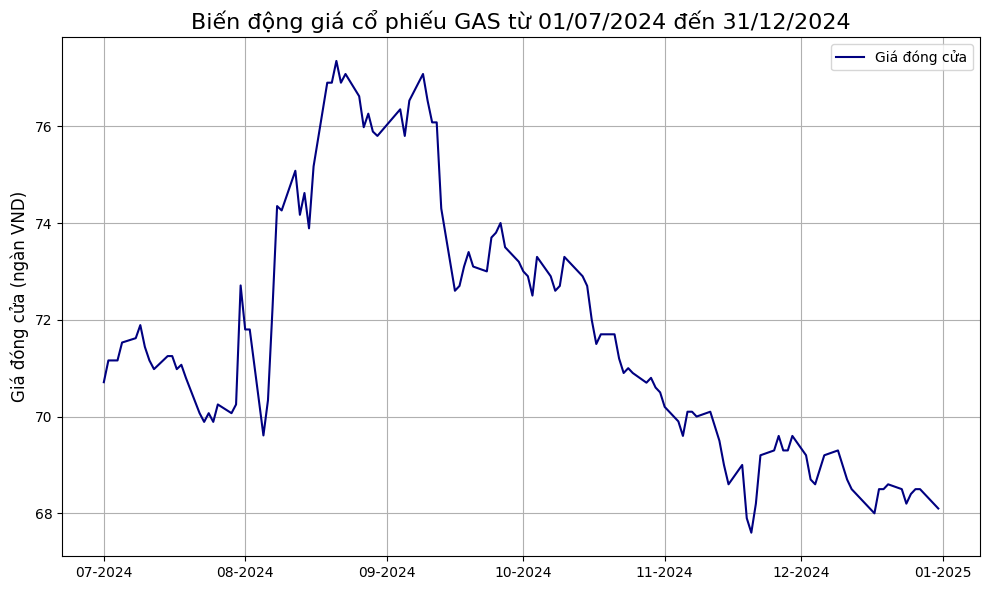

In [33]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

# Giả sử df đã được lấy từ hàm get_stock_data và chứa dữ liệu cổ phiếu
# Đảm bảo rằng cột 'time' là kiểu datetime
df7['time'] = pd.to_datetime(df7['time'])

# Vẽ biểu đồ đường mô tả biến động giá cổ phiếu
plt.figure(figsize=(10, 6))
plt.plot(df7['time'], df7['close'], label='Giá đóng cửa', color='#000080')  # Màu xanh navy

# Thêm tiêu đề và nhãn cho các trục
plt.title('Biến động giá cổ phiếu GAS từ 01/07/2024 đến 31/12/2024', fontsize=16)
plt.ylabel('Giá đóng cửa (ngàn VND)', fontsize=12)

# Tùy chỉnh định dạng nhãn trên trục x (ngày)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))  # Tháng-Năm dạng 07-2024
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Chọn mỗi tháng một nhãn
plt.xticks(rotation=0)

# Hiển thị biểu đồ
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [34]:
from vnstock import *
# Hàm lấy dữ liệu chứng khoán từ Vnstock
def get_stock_data(symbol, start_date="2020-01-01", end_date="2024-12-31"):
    stock = Vnstock().stock(symbol, source="VCI")
    df8 = stock.quote.history(start=start_date, end=end_date, interval="1D")
    if df8 is not None and not df.empty:
        df8["time"] = pd.to_datetime(df8["time"])  # Sửa từ "date" thành "time"
        return df8, stock
    return None, None
df8, stock = get_stock_data("GAS", start_date="2020-01-01", end_date="2024-12-31")
df8

,time,open,high,low,close,volume
0,2020-01-02,61.69,62.68,61.69,62.28,141260
1,2020-01-03,62.28,63.47,62.28,62.42,218980
2,2020-01-06,63.67,64.52,63.34,64.39,431090
3,2020-01-07,64.32,64.32,63.40,63.93,142800
4,2020-01-08,64.92,65.18,63.86,63.86,439260
...,...,...,...,...,...,...
1245,2024-12-25,68.30,68.90,68.30,68.40,456300
1246,2024-12-26,68.60,69.60,68.50,68.50,997100
1247,2024-12-27,68.70,69.00,68.50,68.50,539900
1248,2024-12-30,68.60,68.80,68.20,68.20,402400


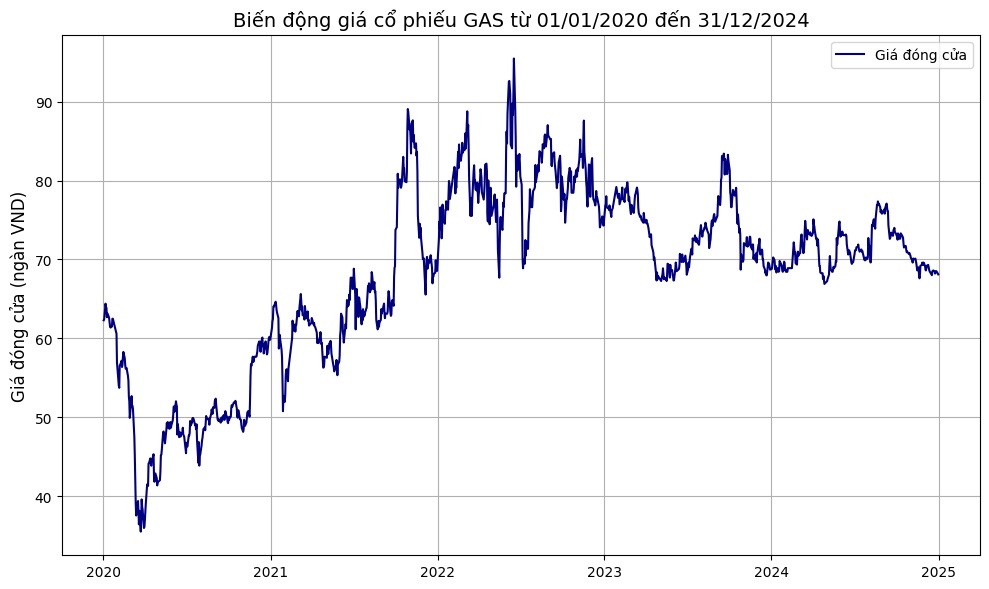

In [35]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ đường mô tả biến động giá cổ phiếu
plt.figure(figsize=(10, 6))
plt.plot(df8['time'], df8['close'], label='Giá đóng cửa', color='#000080')

# Thêm tiêu đề và nhãn cho các trục
plt.title('Biến động giá cổ phiếu GAS từ 01/01/2020 đến 31/12/2024', fontsize=14)
plt.ylabel('Giá đóng cửa (ngàn VND)', fontsize=12)

# Xoay nhãn ngày trên trục x để dễ đọc
plt.xticks(rotation=0)

# Hiển thị biểu đồ
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

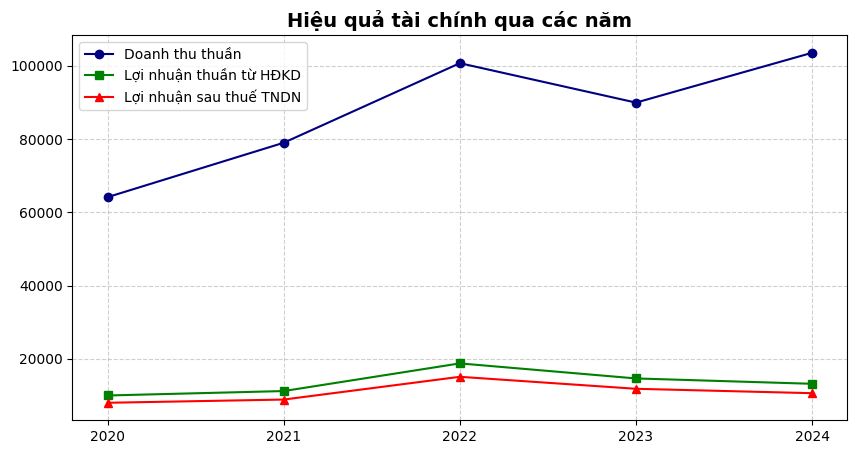

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Các chỉ tiêu cần thiết để tính toán
revenue_label = "KQKD. DOANH THU THUẦN"
operating_income_label = "KQKD. LỢI NHUẬN THUẦN TỪ HOẠT ĐỘNG KINH DOANH"
net_income_after_taxes_label = "KQKD. LỢI NHUẬN SAU THUẾ THU NHẬP DOANH NGHIỆP"

# Lấy giá trị từ transposed_df
def get_values(label):
    row = transposed_df[transposed_df["Chỉ tiêu"] == label]
    return row.iloc[:, 1:].values.flatten() if not row.empty else np.zeros(len(transposed_df.columns[1:]))

# Lấy dữ liệu từng chỉ tiêu
revenue = get_values(revenue_label)
operating_income = get_values(operating_income_label)
net_income_after_taxes = get_values(net_income_after_taxes_label)

# Lấy danh sách các năm
years = transposed_df.columns[1:]

# Vẽ biểu đồ
plt.figure(figsize=(10, 5))
plt.plot(years, revenue, marker='o', linestyle='-', label='Doanh thu thuần', color='#000080')
plt.plot(years, operating_income, marker='s', linestyle='-', label='Lợi nhuận thuần từ HĐKD', color='green')
plt.plot(years, net_income_after_taxes, marker='^', linestyle='-', label='Lợi nhuận sau thuế TNDN', color='red')

# Thêm tiêu đề và nhãn
plt.title("Hiệu quả tài chính qua các năm", fontsize=14, fontweight='bold')
plt.xticks(rotation=0)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Hiển thị biểu đồ
plt.show()


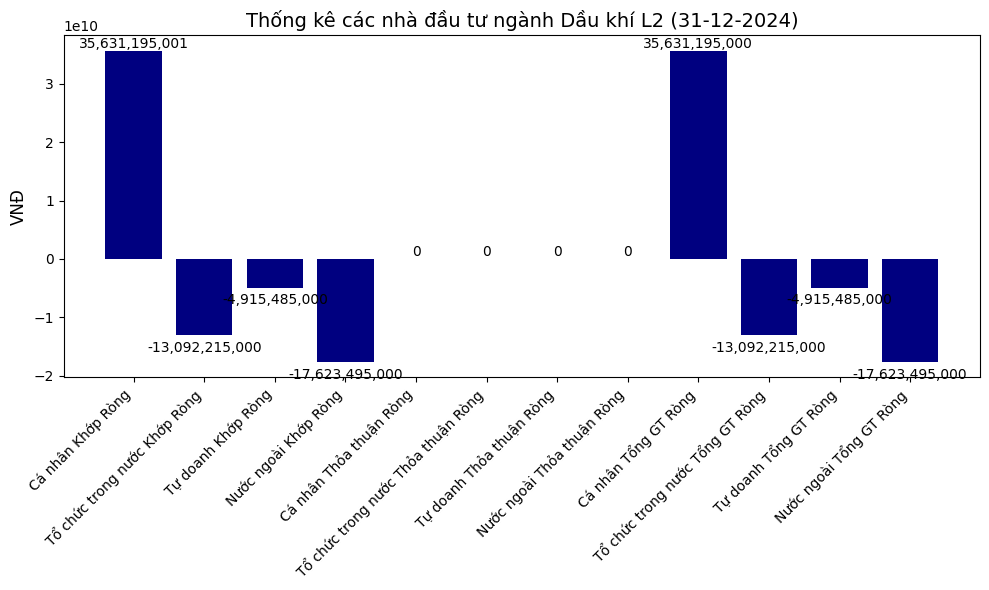

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# Bước 1: Đọc file Excel
# Thay 'path_to_your_file.xlsx' bằng đường dẫn đến file Excel của bạn
file_path = 'FiinTrade_Ngành-chuyên-sâu_Phân-Loại-Nhà-Đầu-Tư__1 NGÀY_20241231.xlsx'
df9 = pd.read_excel(file_path, sheet_name='Sheet1', skiprows=7)  # Bỏ qua 7 dòng đầu để bắt đầu từ tiêu đề bảng

# Bước 2: Lấy dòng "Dầu khí L2" (dòng 9 trong bảng, nhưng sau khi skiprows thì nó là dòng 1 trong DataFrame)
dau_khi_l2 = df9.iloc[2]  # Dòng "Dầu khí L2" là dòng thứ 3 trong DataFrame (index 2)

# Bước 3: Chuẩn bị dữ liệu để vẽ biểu đồ
# Lấy các cột từ cột B trở đi (các giá trị số)
columns = df9.columns[1:]  # Bỏ cột đầu tiên (Tên ngành)
values = dau_khi_l2[1:]   # Bỏ giá trị đầu tiên (Tên ngành)

# Kiểm tra kiểu dữ liệu của values và xử lý phù hợp
if pd.api.types.is_string_dtype(values):
    # Nếu là chuỗi, loại bỏ dấu phẩy và chuyển thành float
    values = values.str.replace(',', '').astype(float)
else:
    # Nếu đã là số, không cần xử lý dấu phẩy
    values = values.astype(float)

# Bước 4: Vẽ biểu đồ cột
plt.figure(figsize=(10, 6))
plt.bar(columns, values, color='#000080')  # Dùng mã màu hex cho navy

# Đặt tiêu đề và nhãn cho biểu đồ
plt.title('Thống kê các nhà đầu tư ngành Dầu khí L2 (31-12-2024)', fontsize=14)
plt.ylabel('VNĐ', fontsize=12)
# Xoay nhãn trục x để dễ đọc
plt.xticks(rotation=45, ha='right')

# Hiển thị giá trị trên mỗi cột
for i, v in enumerate(values):
    # Nếu giá trị là âm, đặt vị trí giá trị thấp hơn một chút
    if v < 0:
        plt.text(i, v - 1000000000, f'{v:,.0f}', ha='center', va='top', color='black')  # Dịch xuống 1 tỷ
    else:
        plt.text(i, v, f'{v:,.0f}', ha='center', va='bottom')

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

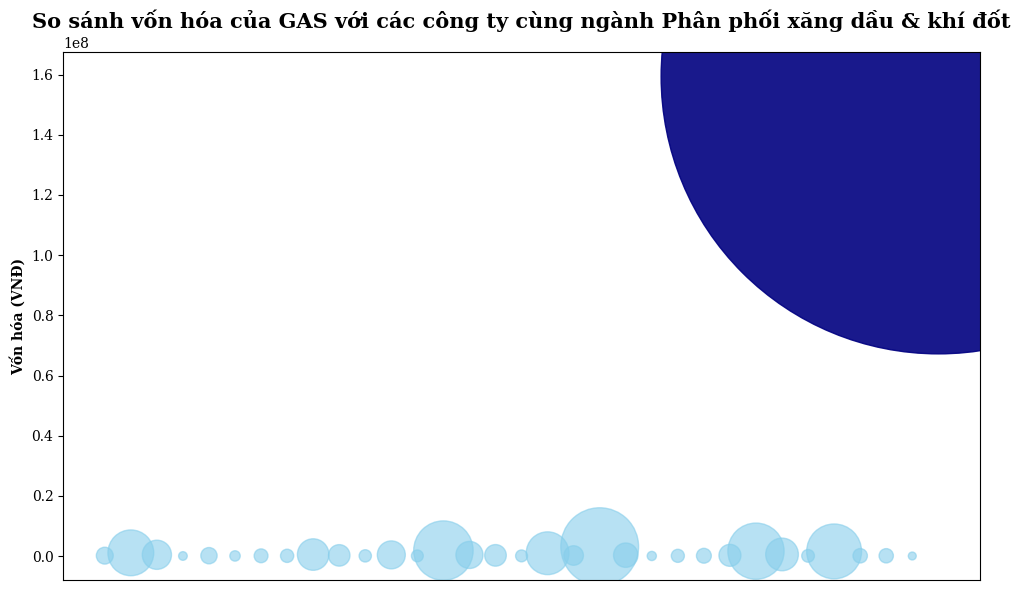

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Đọc file Excel
df_1 = pd.read_excel(r"C:\Users\ADMIN\Downloads\2024-Vietnam.xlsx")
xls = pd.ExcelFile(r"C:\Gói 1\Vietnam_Marketcap.xlsx")
df_1 = df_1[(df_1["Ngành ICB - cấp 4"] == "Phân phối xăng dầu & khí đốt")] 
df_2 = pd.read_excel(xls, sheet_name='Sheet2')

# Xác định khoảng thời gian cần lọc
start_date = "2024-01-01"
end_date = "2025-01-01"

df_2["Ticker"] = df_2["Code"].str.extract(r"VT:([A-Z]+)\(")
unique_tickers = df_1["Mã"]
# Lọc các cổ phiếu thuộc ngành bán lẻ
df_retail = df_2[df_2["Ticker"].isin(unique_tickers)]

# Lọc dữ liệu theo khoảng thời gian
df_retail = df_retail[["Name", "Code"] + [col for col in df_retail.columns if start_date <= str(col) <= end_date]]

#Hàm vẽ bubble chart
def plot_marketcap(df_retail, date_column_prefix="2024-12-31"):
    # Cấu hình chung cho font chữ
    plt.rcParams.update({
        "font.family": "serif",
        "font.size": 10,
        "axes.labelweight": "bold",
        "axes.titlesize": 15,
        "axes.titleweight": "bold"
    })

    # Xử lí NaN
    df_retail_cleaned = df_retail.fillna(0)
    df_plot = df_retail_cleaned.copy()

    # Chuyển tên cột sang chuỗi để tìm ngày 31/12/2024
    date_col = None
    for col in df_retail.columns:
        if str(col).startswith(date_column_prefix):
            date_col = col
            break

    if date_col is None:
        raise ValueError(f"Không tìm thấy cột ngày bắt đầu với {date_column_prefix} trong dữ liệu.")

    # Thêm cột 'Ticker' nếu chưa có
    df_plot["Ticker"] = df_plot["Code"].str.extract(r"VT:([A-Z]+)\(")

    # Lấy vốn hóa tại ngày 31/12/2024
    df_plot["marketcap_3112"] = df_plot[date_col]
    
    # Chia thành GAS và các mã khác
    df_mwg = df_plot[df_plot["Ticker"] == "GAS"]
    df_others = df_plot[df_plot["Ticker"] != "GAS"]

    # Vẽ biểu đồ
    plt.figure(figsize=(10, 6))

    # Các cổ phiếu khác
    plt.scatter(df_others["Ticker"], df_others["marketcap_3112"],
                s=df_others["marketcap_3112"] / 1e3,  # scale size
                c='skyblue', alpha=0.6, label='Khác')

    # GAS nổi bật
    plt.scatter(df_mwg["Ticker"], df_mwg["marketcap_3112"],
                s=df_mwg["marketcap_3112"] / 1e3,
                c='#000080', alpha=0.9, label='GAS')  # Màu navy

    # Tiêu đề và nhãn
    plt.title("So sánh vốn hóa của GAS với các công ty cùng ngành Phân phối xăng dầu & khí đốt")
    plt.ylabel("Vốn hóa (VNĐ)")
    plt.xticks([])  # Không hiển thị nhãn trên trục X

    # Sắp xếp lại bố cục để không bị cắt xén
    plt.tight_layout()

    # Hiển thị đồ thị
    plt.show()

# Sử dụng hàm
plot_marketcap(df_retail)


In [39]:
import pandas as pd

# Tên file Excel
file_name = "VietstockFinance_Du-lieu-doanh-nghiep_20250403-194826.xlsx"

# Đọc file Excel
df10 = pd.read_excel(file_name, skiprows=5, nrows=2, header=None)

# Đặt hàng đầu tiên làm tiêu đề cột
df10.columns = df10.iloc[0]  

# Xóa hàng đầu tiên vì đã dùng làm header
df10 = df10[1:].reset_index(drop=True)

# Lấy thông tin cần thiết
address = df10.iloc[0]["Địa chỉ"]
phone = df10.iloc[0]["Điện thoại"]
website = df10.iloc[0]["Website"]

# In ra kết quả
print("Địa chỉ:", address)
print("Điện thoại:", phone)
print("Website:", website)

Địa chỉ: Tòa nhà PV Gas Tower - số 673 Nguyễn Hữu Thọ - P. Phước Kiển - H. Nhà Bè - Tp. HCM
Điện thoại: (84.28) 3781 6777
Website: https://www.pvgas.com.vn/


In [40]:
import pandas as pd

# Đọc file Excel
file_path = "Vietnam_Marketcap.xlsx"
df11 = pd.read_excel(file_path, sheet_name="Sheet2", header=None)

# Xác định cột ngày 31-12-2024 (không phụ thuộc vào định dạng giờ)
date_target = "2024-12-31"
date_row_index = 3  # Tiêu đề ngày ở hàng 4 (index 3)

try:
    date_col_index = next(i for i, d in enumerate(df11.iloc[date_row_index].astype(str)) if date_target in d)
except StopIteration:
    raise ValueError(f"Không tìm thấy cột ngày {date_target} trong file Excel.")

# Xác định dòng chứa "PETROVIETNAM GAS - MARKET VALUE"
row_label = "PETROVIETNAM GAS - MARKET VALUE"

try:
    row_index = df11[df11.iloc[:, 0].astype(str).str.strip().str.contains(row_label, case=False, na=False)].index[0]
except IndexError:
    raise ValueError(f"Không tìm thấy dòng '{row_label}' trong file Excel. Kiểm tra lại tên!")

# Lấy giá trị tại ô tương ứng
market_cap = df11.iloc[row_index, date_col_index]

print(f"Vốn hóa thị trường tại ngày {date_target} của GAS (triệu VND): {market_cap}")

Vốn hóa thị trường tại ngày 2024-12-31 của GAS (triệu VND): 159536000


In [41]:
import zipfile

zip_path = "ttf.zip"
extract_path = "extracted_files"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [42]:
from fpdf import FPDF
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
import os
import tempfile
import numpy as np
from vnstock import *

# Khai báo thông tin cần thiết
today = datetime.date(2024, 12, 31) 
market_cap_tty = market_cap / 1_000_000
data = (
    ("Tên công ty", company_name),
    ("Mã chứng khoán", stock_symbol),
    ("Sàn giao dịch", exchange_code),
    ("Ngành (ICB)", industry),
    ("Địa chỉ", address),
    ("Điện thoại", phone),
    ("Website", website),
    ("Vốn hóa thị trường", f"{market_cap_tty:,.3f} tỷ VNĐ")
)

# Lấy dữ liệu từ code trước (BALANCE SHEET)
total_current_assets = [f"{value:,.2f}" for value in total_current_assets]  
ppe = [f"{value:,.2f}" for value in ppe]
total_net = [f"{value:,.2f}" for value in total_net] 
total_assets = [f"{value:,.2f}" for value in total_assets]
total_current_liabilities = [f"{value:,.2f}" for value in total_current_liabilities]
total_long_term_debt = [f"{value:,.2f}" for value in total_long_term_debt]
total_liabilities = [f"{value:,.2f}" for value in total_liabilities]

# Lấy dữ liệu từ code trước (FUNDAMENTAL) 
ebitda = [f"{value:,.2f}" for value in ebitda]  

# Lấy dữ liệu mới (INCOME STATEMENT)
revenue = [f"{value:,.2f}" for value in revenue]
operating_income = [f"{value:,.2f}" for value in operating_income]
total_operating_expense = [f"{value:,.2f}" for value in total_operating_expense]
net_income_before_taxes = [f"{value:,.2f}" for value in net_income_before_taxes]
net_income_after_taxes = [f"{value:,.2f}" for value in net_income_after_taxes]
net_income_before_extraordinary_items = [f"{value:,.2f}" for value in net_income_before_extraordinary_items]

# Lấy dữ liệu mới (PROFITABILITY ANALYSIS)
roe = [f"{value * 100:,.2f}" for value in roe]
roa = [f"{value * 100:,.2f}" for value in roa]
income_after_tax_margin = [f"{value * 100:,.2f}" for value in income_after_tax_margin]
revenue_to_total_assets = [f"{value * 100:,.2f}" for value in revenue_to_total_assets]
long_term_debt_to_equity = [f"{value * 100:,.2f}" for value in long_term_debt_to_equity]
total_debt_to_equity = [f"{value * 100:,.2f}" for value in total_debt_to_equity]
ros = [f"{value * 100:,.2f}" for value in ros]

# Dữ liệu bảng
balance_sheet_data = {
    "Tổng tài sản ngắn hạn": total_current_assets,
    "Tài sản cố định hữu hình": ppe,
    "Tài sản ròng": total_net,
    "Tổng tài sản": total_assets,
    "Tổng nợ ngắn hạn": total_current_liabilities,
    "Tổng nợ dài hạn": total_long_term_debt,
    "Tổng nợ": total_liabilities
}

fundamental_data = {
    "EBITDA": ebitda
}

income_statement_data = {
    "Doanh thu thuần": revenue,
    "Lợi nhuận thuần từ hoạt động kinh doanh": operating_income,
    "Tổng chi phí hoạt động kinh doanh": total_operating_expense,
    "Lợi nhuận trước thuế thu nhập doanh nghiệp": net_income_before_taxes,
    "Lợi nhuận sau thuế thu nhập doanh nghiệp": net_income_after_taxes,
    "Lợi nhuận trước các khoản mục đặc biệt": net_income_before_extraordinary_items
}

profitability_analysis_data = {
    "Lợi nhuận trên vốn chủ sở hữu (ROE), %": roe,
    "Lợi nhuận trên tài sản (ROA), %": roa,
    "Biên lợi nhuận sau thuế, %": income_after_tax_margin,
    "Doanh thu trên tổng tài sản, %": revenue_to_total_assets,
    "Tỷ lệ nợ dài hạn trên vốn chủ sở hữu, %": long_term_debt_to_equity,
    "Tỷ lệ tổng nợ trên vốn chủ sở hữu, %": total_debt_to_equity,
    "Lợi nhuận trên doanh thu (ROS), %": ros
}


# Các chỉ tiêu cần thiết để tính toán
revenue_label = "KQKD. DOANH THU THUẦN"
operating_income_label = "KQKD. LỢI NHUẬN THUẦN TỪ HOẠT ĐỘNG KINH DOANH"
net_income_after_taxes_label = "KQKD. LỢI NHUẬN SAU THUẾ THU NHẬP DOANH NGHIỆP"

# Lấy giá trị từ transposed_df
def get_values(label):
    row = transposed_df[transposed_df["Chỉ tiêu"] == label]
    return row.iloc[:, 1:].values.flatten() if not row.empty else np.zeros(len(transposed_df.columns[1:]))

# Lấy dữ liệu từng chỉ tiêu
revenue = get_values(revenue_label)
operating_income = get_values(operating_income_label)
net_income_after_taxes = get_values(net_income_after_taxes_label)

# Lấy danh sách các năm
years = transposed_df.columns[1:]

# Đọc file Excel
file_path = 'FiinTrade_Ngành-chuyên-sâu_Phân-Loại-Nhà-Đầu-Tư__1 NGÀY_20241231.xlsx'
df9 = pd.read_excel(file_path, sheet_name='Sheet1', skiprows=7)

# Lấy dòng "Dầu khí L2"
dau_khi_l2 = df9.iloc[2]

# Chuẩn bị dữ liệu để vẽ biểu đồ
columns = df9.columns[1:]
values = dau_khi_l2[1:]

# Kiểm tra và chuyển đổi giá trị nếu cần
if pd.api.types.is_string_dtype(values):
    values = values.str.replace(',', '').astype(float)
else:
    values = values.astype(float)

import seaborn as sns
# Đọc file Excel
df_1 = pd.read_excel(r"C:\Users\ADMIN\Downloads\2024-Vietnam.xlsx")
xls = pd.ExcelFile(r"C:\Gói 1\Vietnam_Marketcap.xlsx")
df_1 = df_1[(df_1["Ngành ICB - cấp 4"] == "Phân phối xăng dầu & khí đốt")] 
df_2 = pd.read_excel(xls, sheet_name='Sheet2')

# Xác định khoảng thời gian cần lọc
start_date = "2024-01-01"
end_date = "2025-01-01"

df_2["Ticker"] = df_2["Code"].str.extract(r"VT:([A-Z]+)\(")
unique_tickers = df_1["Mã"]
# Lọc các cổ phiếu thuộc ngành bán lẻ
df_retail = df_2[df_2["Ticker"].isin(unique_tickers)]

# Lọc dữ liệu theo khoảng thời gian
df_retail = df_retail[["Name", "Code"] + [col for col in df_retail.columns if start_date <= str(col) <= end_date]]


# Tạo lớp PDF kế thừa từ FPDF
class PDF(FPDF):
    def header(self):
        # Thêm phông chữ 
        pdf.add_font("DejaVu", "", "extracted_files/ttf/DejaVuSans.ttf", uni=True)  # Regular
        pdf.add_font("DejaVu", "B", "extracted_files/ttf/DejaVuSans-Bold.ttf", uni=True)  # Bold
        pdf.add_font("DejaVu", "I", "extracted_files/ttf/DejaVuSans-Oblique.ttf", uni=True)  # Italic
        pdf.add_font("DejaVu", "BI", "extracted_files/ttf/DejaVuSans-BoldOblique.ttf", uni=True)  # Bold Italic
        
        self.set_fill_color(0, 0, 128)  # Màu xanh navy (#000080)
        self.rect(0, 0, self.w, 38, 'F')# Tô nền header toàn trang (cao 20px) 
        # Sử dụng phông chữ DejaVu Sans, cỡ 16
        self.set_text_color(255, 255, 255)  # Màu xám đậm (RGB: 64, 64, 64)
        self.set_font('DejaVu', 'B', 16)
        self.cell(0, 10, company_name.upper(), 0, 1, 'R')  # Chuyển thành chữ hoa và căn phải

        # Dòng chứa Document Date, căn lề phải
        self.set_font('DejaVu', '', 10)  # Phông chữ DejaVu Sans, cỡ 8 cho Document Date
        self.cell(0, 5, f"Ngày: {today.strftime('%d-%b-%Y')}", 0, 1, 'R')

         # Thêm giá cổ phiếu vào vị trí giữa dòng PVGAS và Document Date
        if closing_price is not None:
            self.cell(0, 5, f"Giá đóng cửa: {closing_price:,.3f}", 0, 1, 'R')
        
        self.ln(10)  # Thêm một khoảng trống nhỏ sau phần header
        
    def footer(self):
        # Vị trí 1.5 cm từ đáy trang
        self.set_y(-10)
        self.set_font('DejaVu', 'I', 8)  # Phông chữ nghiêng
        # Sử dụng new_x và new_y thay cho ln để không gặp cảnh báo DeprecationWarning
        self.cell(0, 5, f'Page {self.page_no()} of {{nb}}', 0, 1, 'C', new_x='RIGHT', new_y='NEXT')
    def chapter_title(self, title):
        self.set_text_color(0, 0, 128)  # Màu xanh dương cho chữ
        self.set_font('DejaVu', 'B', 13)  # Phông chữ đậm, cỡ 12 cho tiêu đề
        self.cell(0, 5, title, 0, 1, 'L')  # Title căn trái
        self.ln(5)

    # Thêm phương thức mới để in thông tin chung
    def create_table_information(self, data): 
        # Vẽ đường nét đứt phía trên bảng
        self.set_draw_color(0, 0, 0)  # Màu xám đậm cho đường kẻ
        self.dashed_line(10, self.get_y(), 200, self.get_y(), 1, 1)  # (x1, y1, x2, y2, độ dài nét, khoảng cách)
    
        self.set_text_color(0, 0, 0)  # Màu chữ mặc định (đen)
        row_count = 0
    
        for item in data:
            # Tô màu nền xanh pastel cho hàng chẵn
            if row_count % 2 == 0:
                self.set_fill_color(230, 240, 250)  # Màu xanh pastel 
            else:
                self.set_fill_color(255, 255, 255)  # Màu trắng
    
            # Cột "Thông tin" có chữ xám đậm
            self.set_text_color(80, 80, 80)  # Màu xám 
            self.set_font('DejaVu', '', 8)  # Đậm hơn một chút
    
            self.cell(50, 6, item[0], 0, 0, 'L', fill=True)  
    
            # Cột "Giá trị" trở về màu đen bình thường
            self.set_text_color(0, 0, 0)  
            self.set_font('DejaVu', '', 8)  # Chữ thường
    
            self.cell(140, 6, item[1], 0, 1, 'L', fill=True)  
    
            row_count += 1
        # Vẽ đường nét đứt phía dưới bảng
        self.set_draw_color(0, 0, 0)
        end_y = self.get_y()  # Lưu vị trí kết thúc bảng
        self.dashed_line(10, end_y, 200, end_y, 1, 1)  # Đường nét đứt ngang
    
        self.ln(8)  # Thêm một khoảng trống sau bảng
    
    def create_table(self, title, data, years, header_color):
        self.set_font("DejaVu", "B", 8)

        # Chiều rộng trang A4 = 210mm, trừ đi lề 2 bên (10mm mỗi bên)
        page_width = 210 - 20  # 190mm là không gian sử dụng được
        col_width = page_width * 0.35  # 35% chiều rộng cho cột đầu tiên
        year_width = (page_width * 0.65) / len(years)  # 65% còn lại chia đều cho các năm

        self.set_x(10)  # Đặt vị trí x để bảng căn sát lề trái

        # Tiêu đề bảng trong ô đầu tiên với màu nền theo yêu cầu
        self.set_fill_color(*header_color)  # Đặt màu nền theo bảng cụ thể
        self.set_text_color(255, 255, 255)  # Màu chữ trắng cho dòng đầu tiên
        self.cell(col_width, 6, title, 0, 0, "L", fill=True)  # Không có viền
        for year in years:
            self.cell(year_width, 6, year, 0, 0, "R", fill=True)  # Căn phải
        self.ln()

        # In dữ liệu từng hàng
        self.set_x(10)  # Đảm bảo từng hàng bắt đầu từ lề trái
        self.set_font("DejaVu", "", 8)
        self.set_text_color(0, 0, 0)  # Đặt lại màu chữ đen cho các dòng tiếp theo
        row_count = 0
        line_height = 6

        for key, values in data.items():
            # Tô màu xen kẽ cho từng dòng (trừ dòng đầu tiên)
            self.set_fill_color(230, 240, 250) if row_count % 2 == 0 else self.set_fill_color(255, 255, 255)

            # In cột đầu tiên
            self.cell(col_width, line_height, key, 0, 0, "L", fill=True)

            # In dữ liệu theo từng năm (không viền, căn phải)
            for value in values:
                self.cell(year_width, line_height, value, 0, 0, "R", fill=True)
            self.ln()
            row_count += 1

        self.ln(10)  # Tạo khoảng trống 10mm giữa các bảng
        
    def sau_thang (self, df, title):
        df['time'] = pd.to_datetime(df['time'])

        # Tạo file ảnh tạm
        with tempfile.NamedTemporaryFile(delete=False, suffix=".png") as tmpfile:
            image_path = tmpfile.name

        # Vẽ biểu đồ
        plt.figure(figsize=(10, 6))
        plt.plot(df['time'], df['close'], label='Giá đóng cửa', color='#000080')
        plt.title(title, fontsize=16)
        plt.ylabel('Giá đóng cửa (ngàn VND)', fontsize=12)
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
        plt.xticks(rotation=0)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.savefig(image_path, dpi=300)  # Xuất ảnh chất lượng cao
        plt.close()

        # Thêm ảnh vào PDF (giữ trong cùng trang nếu còn trống)
        self.image(image_path, x=10, w=190)

        # Xóa file ảnh tạm
        if os.path.exists(image_path):
            os.remove(image_path)

    def text(self, text, line_length=200, line_height=1, line_gap=1, chart_height=50):
        # Đặt màu chữ đen và phông chữ
        self.set_text_color(0, 0, 0)  # Màu chữ đen
        self.set_font('DejaVu', '', 8)  # Phông chữ DejaVu, cỡ chữ 10
        
        # In đoạn văn
        self.multi_cell(0, 5, text)

    def nam_nam(self, df):
        df['time'] = pd.to_datetime(df['time'])
    
        # Tạo file ảnh tạm
        with tempfile.NamedTemporaryFile(delete=False, suffix=".png") as tmpfile:
            image_path = tmpfile.name
    
        # Vẽ biểu đồ
        plt.figure(figsize=(10, 6))
        plt.plot(df['time'], df['close'], label='Giá đóng cửa', color='#000080')
        plt.title('Biến động giá cổ phiếu GAS từ 01/01/2020 đến 31/12/2024', fontsize=14)
        plt.ylabel('Giá đóng cửa (ngàn VND)', fontsize=12)
        plt.xticks(rotation=0)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.savefig(image_path, dpi=300)  # Xuất ảnh chất lượng cao
        plt.close()
    
        # Thêm ảnh vào PDF
        self.image(image_path, x=10, w=190)
    
        # Xóa file ảnh tạm
        if os.path.exists(image_path):
            os.remove(image_path)


    def finance(self, df):
        # Tạo file ảnh tạm
        with tempfile.NamedTemporaryFile(delete=False, suffix=".png") as tmpfile:
            image_path = tmpfile.name

        # Vẽ biểu đồ
        plt.plot(years, revenue, marker='o', linestyle='-', label='Doanh thu thuần', color='#000080')
        plt.plot(years, operating_income, marker='s', linestyle='-', label='Lợi nhuận thuần từ HĐKD', color='green')
        plt.plot(years, net_income_after_taxes, marker='^', linestyle='-', label='Lợi nhuận sau thuế TNDN', color='red')
        
        # Thêm tiêu đề và nhãn
        plt.title("Hiệu quả tài chính qua các năm", fontsize=14, fontweight='bold')
        plt.xticks(rotation=0)
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)

        plt.savefig(image_path, dpi=300)  # Xuất ảnh chất lượng cao
        plt.close()
        # Thêm ảnh vào PDF (giữ trong cùng trang nếu còn trống)
        self.image(image_path, x=10, w=190)

        # Xóa file ảnh tạm
        if os.path.exists(image_path):
            os.remove(image_path)
    
    def nha_dau_tu(self, df):

        # Tạo file ảnh tạm
        with tempfile.NamedTemporaryFile(delete=False, suffix=".png") as tmpfile:
            image_path = tmpfile.name

        # Vẽ biểu đồ cột
        plt.figure(figsize=(10, 6))
        plt.bar(columns, values, color='#000080')
        
        plt.title('Thống kê các nhà đầu tư ngành Dầu khí L2 (31-12-2024)', fontsize=14)
        plt.ylabel('VNĐ', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        
        for i, v in enumerate(values):
            if v < 0:
                plt.text(i, v - 1000000000, f'{v:,.0f}', ha='center', va='top', color='black')
            else:
                plt.text(i, v, f'{v:,.0f}', ha='center', va='bottom')
        plt.tight_layout()
        plt.savefig(image_path, dpi=300)  # Xuất ảnh chất lượng cao
        plt.close()
        # Thêm ảnh vào PDF (giữ trong cùng trang nếu còn trống)
        self.image(image_path, x=10, w=190)

        # Xóa file ảnh tạm
        if os.path.exists(image_path):
            os.remove(image_path)

    def so_sanh_nganh(self, df):
        # Tạo file ảnh tạm
        with tempfile.NamedTemporaryFile(delete=False, suffix=".png") as tmpfile:
            image_path = tmpfile.name
            
        #Vẽ biểu đồ:
        #Hàm vẽ bubble chart
        def plot_marketcap(df_retail, date_column_prefix="2024-12-31"):
            # Cấu hình chung cho font chữ
            plt.rcParams.update({
                "font.family": "serif",
                "font.size": 10,
                "axes.labelweight": "bold",
                "axes.titlesize": 15,
                "axes.titleweight": "bold"
            })
        
            # Xử lí NaN
            df_retail_cleaned = df_retail.fillna(0)
            df_plot = df_retail_cleaned.copy()
        
            # Chuyển tên cột sang chuỗi để tìm ngày 31/12/2024
            date_col = None
            for col in df_retail.columns:
                if str(col).startswith(date_column_prefix):
                    date_col = col
                    break
        
            if date_col is None:
                raise ValueError(f"Không tìm thấy cột ngày bắt đầu với {date_column_prefix} trong dữ liệu.")
        
            # Thêm cột 'Ticker' nếu chưa có
            df_plot["Ticker"] = df_plot["Code"].str.extract(r"VT:([A-Z]+)\(")
        
            # Lấy vốn hóa tại ngày 31/12/2024
            df_plot["marketcap_3112"] = df_plot[date_col]
            
            # Chia thành GAS và các mã khác
            df_mwg = df_plot[df_plot["Ticker"] == "GAS"]
            df_others = df_plot[df_plot["Ticker"] != "GAS"]
        
            # Vẽ biểu đồ
            plt.figure(figsize=(10, 6))
        
            # Các cổ phiếu khác
            plt.scatter(df_others["Ticker"], df_others["marketcap_3112"],
                        s=df_others["marketcap_3112"] / 1e3,  # scale size
                        c='skyblue', alpha=0.6, label='Khác')
        
            # GAS nổi bật
            plt.scatter(df_mwg["Ticker"], df_mwg["marketcap_3112"],
                        s=df_mwg["marketcap_3112"] / 1e3,
                        c='#000080', alpha=0.9, label='GAS')  # Màu navy
        
            # Tiêu đề và nhãn
            plt.title("So sánh vốn hóa của GAS với các công ty cùng ngành Phân phối xăng dầu & khí đốt")
            plt.ylabel("Vốn hóa (VNĐ)")
            plt.xticks([])  # Không hiển thị nhãn trên trục X
        
            # Sắp xếp lại bố cục để không bị cắt xén
            plt.tight_layout()

        # Sử dụng hàm
        plot_marketcap(df_retail)

        plt.savefig(image_path, dpi=300)  # Xuất ảnh chất lượng cao
        plt.close()
        # Thêm ảnh vào PDF (giữ trong cùng trang nếu còn trống)
        self.image(image_path, x=10, w=190)

        # Xóa file ảnh tạm
        if os.path.exists(image_path):
            os.remove(image_path)

# Khởi tạo PDF
pdf = PDF()
pdf.alias_nb_pages()
pdf.add_page()

business_summary= """
Tổng Công ty Khí Việt Nam-CTCP (GAS) có tiền thân là Công ty Khí đốt được thành lập vào năm 1990, là đơn vị thành viên thuộc Tập Đoàn Dầu Khí Quốc gia Việt Nam. GAS chủ yếu hoạt động trong lĩnh vực thu gom, vận chuyển, lưu trữ, chế biến, xuất khẩu, nhập khẩu, kinh doanh khí và các sản phẩm khí. Công ty hiện đang vận hành 3 hệ thống đường ống khí Cửu Long, Nam côn Sơn ở miền Đông Nam và PM3 ở vùng Tây Nam và 2 nhà máy chế biến khí là Dinh Cổ và Nam Côn Sơn ở khu vực Đông Nam và hệ thống Kho LPG rộng khắp cả nước. GAS có năng lực sản xuất 450.000 - 500.000 tấn LPG/năm và 70.000 tấn condensate/năm. Tổng Công ty giữ vị thế số 1 về cung cấp LPG với hơn 70% thị phần trên thị trường LPG Việt Nam. GAS được niêm yết trên Sở Giao dịch Chứng khoán Thành phố Hồ Chí Minh (HOSE) từ năm 2012.
"""

nhanxetsauthang = """
Biểu đồ cho thấy giá cổ phiếu GAS có nhiều biến động trong giai đoạn từ tháng 7 đến tháng 12 năm 2024. Ban đầu, giá dao động quanh mức 71-72 nghìn VND, sau đó giảm xuống khoảng 70 nghìn VND vào cuối tháng 7. Đến giữa tháng 8, giá có sự tăng trưởng mạnh mẽ, đạt đỉnh gần 77 nghìn VND vào đầu tháng 9. Sau đó, giá bắt đầu xu hướng giảm dần, trải qua nhiều đợt điều chỉnh lên xuống, và kết thúc tháng 12 ở mức khoảng 68 nghìn VND. Nhìn chung, cổ phiếu GAS có một đợt tăng trưởng đáng kể vào giữa quý 3 năm 2024, nhưng sau đó lại trải qua một xu hướng giảm kéo dài đến cuối năm.
"""

nhanxetnamnam = """
Biểu đồ giá cổ phiếu GAS từ đầu năm 2020 đến cuối năm 2024 cho thấy nhiều biến động đáng chú ý. Giai đoạn đầu năm 2020 chứng kiến sự sụt giảm mạnh do ảnh hưởng của đại dịch COVID-19, giá rơi xuống mức thấp nhất khoảng 35-40 nghìn VND. Sau đó, giá phục hồi và có xu hướng tăng trưởng chậm rãi trong năm 2021, dao động quanh mức 50-60 nghìn VND.
Đến năm 2022, cổ phiếu GAS có sự tăng trưởng đột biến, đạt đỉnh hơn 90 nghìn VND vào giữa năm. Tuy nhiên, sau đó giá điều chỉnh giảm mạnh và tiếp tục có nhiều biến động trong năm 2023, dao động trong biên độ rộng từ 70 đến 85 nghìn VND. Năm 2024, giá cổ phiếu GAS có xu hướng giảm dần từ đầu năm đến cuối năm, kết thúc ở mức khoảng 68 nghìn VND. Nhìn chung, cổ phiếu GAS trải qua một giai đoạn biến động mạnh trong 5 năm, với một đợt tăng trưởng ấn tượng vào năm 2022 nhưng sau đó lại có xu hướng giảm trở lại.
"""

nhanxetcautrucvon =  """
Biểu đồ cấu trúc vốn từ năm 2020 đến 2024 cho thấy sự thay đổi trong cơ cấu tài chính của doanh nghiệp. Tổng tài sản tăng đều, từ 63.208 (2020) lên 87.754 (2023) – mức đỉnh trong giai đoạn, trước khi giảm nhẹ xuống 81.894 (2024), phản ánh sự mở rộng quy mô và sau đó điều chỉnh. Tỷ lệ vốn chủ sở hữu (màu vàng) giảm từ 78,3% (2020) xuống 75,2% (2024), cho thấy tỷ trọng vốn tự có giảm nhẹ nhưng vẫn ở mức cao, đảm bảo sự ổn định. Ngược lại, tỷ lệ nợ (màu xanh) dao động, đạt đỉnh 33,7% vào năm 2021, sau đó giảm dần còn 26,0% (2022), 25,6% (2023) và 24,8% (2024), với mức thấp nhất là 21,7% vào năm 2020. Việc giảm tỷ lệ nợ sau năm 2021 cho thấy doanh nghiệp điều chỉnh chiến lược tài chính, giảm phụ thuộc vào vốn vay. Dù tổng tài sản đạt đỉnh vào năm 2023, tỷ lệ nợ lúc này đã giảm, thể hiện sự quản lý tài chính thận trọng hơn. Nhìn chung, cấu trúc vốn đang chuyển biến tích cực, nhưng doanh nghiệp cần duy trì cân bằng để tránh rủi ro tài chính.
"""

nhanxetfinance = """
Biểu đồ hiệu quả tài chính từ 2020 đến 2024 cho thấy doanh thu thường (màu xanh dương) tăng trưởng vượt bậc, từ khoảng 6.000 lên hơn 10.000 vào năm 2024, với đà tăng mạnh qua các năm và đạt đỉnh cao nhất trong giai đoạn này. Tuy nhiên, lợi nhuận thuần từ hoạt động kinh doanh (màu xanh lá) và lợi nhuận sau thuế thu nhập doanh nghiệp (màu đỏ) lại kém khả quan, dao động loanh quanh dưới mức 2.000, với xu hướng tăng vào 2022 nhưng giảm dần về sau. Khoảng cách giữa doanh thu và lợi nhuận ngày càng nới rộng, đặc biệt từ 2022, cho thấy chi phí vận hành hoặc thuế đang ảnh hưởng nặng nề đến lợi nhuận ròng, dù doanh thu tăng mạnh. Điều này đặt ra thách thức lớn trong việc tối ưu hóa hiệu quả tài chính. Để đảm bảo tăng trưởng bền vững, doanh nghiệp cần tập trung vào quản lý chi phí chặt chẽ hơn, đồng thời tìm cách cải thiện tỷ suất lợi nhuận, tận dụng doanh thu cao để tạo ra giá trị thực chất hơn.
"""

nhanxetnhadautu = """
Biểu đồ thống kê các nhà đầu tư ngành Dầu khí L2 (31/12/2024) cho thấy cá nhân tổng giá trị ròng đạt 35.631.195.000 VND, trong đó cá nhân khớp ròng đóng góp lớn với 35.631.195.001 VND, thể hiện sự áp đảo của nhóm này. Ngược lại, tổ chức trong nước tổng giá trị ròng ghi nhận mức âm -13.092.215.000 VND, cho thấy họ đang rút vốn hoặc chịu lỗ. Tương tự, nước ngoài tổng giá trị ròng cũng có giá trị đầu tư âm -17.623.215.000 VND, phản ánh xu hướng thoái vốn hoặc hiệu suất kém. Tự doanh khớp ròng cũng ghi nhận mức âm -4.915.485.000 VND, cho thấy khó khăn trong hoạt động đầu tư. Các nhóm khác như cá nhân nước ngoài (GT) và tổ chức nước ngoài (GT) không có giá trị đầu tư, thể hiện sự thiếu quan tâm hoặc không tham gia vào ngành. Biểu đồ phản ánh ngành Dầu khí L2 đang phụ thuộc hoàn toàn vào cá nhân khớp ròng, trong khi các nhóm khác gặp khó khăn hoặc không mặn mà, đặt ra thách thức trong việc thu hút nguồn vốn đa dạng hơn để phát triển bền vững.
"""

nhanxetsosanhnganh = """
Biểu đồ so sánh vốn hóa của các công ty ngành Phân phối xăng dầu và khí đốt (31/12/2024) cho thấy sự chênh lệch rõ rệt. GAS (biểu thị bằng vòng tròn lớn màu xanh đậm) có vốn hóa vượt trội, ước tính khoảng 1.6 x 10^8 VND, chiếm vị trí áp đảo so với các công ty cùng ngành. Trong khi đó, các công ty khác (các vòng tròn màu xanh nhạt) có vốn hóa dao động từ 0 đến 0.2 x 10^8 VND, với phần lớn tập trung dưới mức 0.1 x 10^8 VND, cho thấy quy mô vốn hóa của họ nhỏ hơn GAS hàng chục lần. Điều này phản ánh vị thế dẫn đầu của GAS trong ngành, có thể nhờ vào thị phần lớn, thương hiệu mạnh hoặc hiệu quả hoạt động vượt trội. Tuy nhiên, sự chênh lệch lớn cũng cho thấy ngành này có sự phân hóa rõ rệt, với các công ty nhỏ hơn đang gặp khó khăn trong việc cạnh tranh hoặc mở rộng quy mô. Để phát triển bền vững, các công ty nhỏ cần chiến lược cải thiện hiệu quả hoặc tìm kiếm cơ hội hợp tác, trong khi GAS cần duy trì lợi thế cạnh tranh để giữ vững vị thế.
"""

# Thêm thông tin chung
pdf.chapter_title("THÔNG TIN CHUNG")
profitability_analysis_title = "PHÂN TÍCH KHẢ NĂNG SINH LỜI"
pdf.create_table_information(data)
pdf.text(business_summary)
pdf.chapter_title("CHỈ SỐ TÀI CHÍNH")

# Thêm 4 bảng tài chính bên dưới thông tin chung, với màu dòng đầu tiên khác nhau & chữ trắng
pdf.create_table("BẢNG CÂN ĐỐI KẾ TOÁN", balance_sheet_data, years, (128, 0, 0))  # Đỏ đậm
pdf.create_table("PHÂN TÍCH CƠ BẢN", fundamental_data, years, (0, 100, 0))  # Xanh lá đậm
pdf.create_table("BÁO CÁO THU NHẬP", income_statement_data, years, (75, 0, 130))  # Tím đậm
pdf.create_table(profitability_analysis_title, profitability_analysis_data, years, (218, 165, 32))

pdf.chapter_title("BIỂU ĐỒ")
pdf.sau_thang(df7, "Biến động giá cổ phiếu GAS từ 01/07/2024 đến 31/12/2024")
pdf.text(nhanxetsauthang)
pdf.nam_nam(df8)
pdf.text(nhanxetnamnam)
pdf.finance(transposed_df)
pdf.text(nhanxetfinance)
pdf.nha_dau_tu(df9)
pdf.text(nhanxetnhadautu)
pdf.so_sanh_nganh(df_retail)
pdf.text(nhanxetsosanhnganh)

# Xuất PDF
file_name = f"{stock_symbol}_report.pdf"
pdf.output(file_name)

print("✅ PDF đã được tạo thành công!")

"uni" parameter is deprecated since v2.5.1, unused and will soon be removed
"uni" parameter is deprecated since v2.5.1, unused and will soon be removed
"uni" parameter is deprecated since v2.5.1, unused and will soon be removed
"uni" parameter is deprecated since v2.5.1, unused and will soon be removed
The parameter "ln" is deprecated since v2.5.2. Instead of ln=1 use new_x=XPos.LMARGIN, new_y=YPos.NEXT.
The parameter "ln" is deprecated since v2.5.2. Instead of ln=1 use new_x=XPos.LMARGIN, new_y=YPos.NEXT.
The parameter "ln" is deprecated since v2.5.2. Instead of ln=1 use new_x=XPos.LMARGIN, new_y=YPos.NEXT.
The parameter "ln" is deprecated since v2.5.2. Instead of ln=1 use new_x=XPos.LMARGIN, new_y=YPos.NEXT.
dashed_line() is deprecated since v2.4.6, and will be removed in a future release. Use set_dash_pattern() and the normal drawing operations instead.
The parameter "ln" is deprecated since v2.5.2. Instead of ln=0 use new_x=XPos.RIGHT, new_y=YPos.TOP.
The parameter "ln" is deprecat

✅ PDF đã được tạo thành công!


The parameter "ln" is deprecated since v2.5.2. Instead of ln=1 use new_x=XPos.LMARGIN, new_y=YPos.NEXT.
"uni" parameter is deprecated since v2.5.1, unused and will soon be removed
Core font or font already added 'dejavu': doing nothing
"uni" parameter is deprecated since v2.5.1, unused and will soon be removed
Core font or font already added 'dejavuB': doing nothing
"uni" parameter is deprecated since v2.5.1, unused and will soon be removed
Core font or font already added 'dejavuI': doing nothing
"uni" parameter is deprecated since v2.5.1, unused and will soon be removed
Core font or font already added 'dejavuBI': doing nothing
The parameter "ln" is deprecated since v2.5.2. Instead of ln=1 use new_x=XPos.LMARGIN, new_y=YPos.NEXT.
The parameter "ln" is deprecated since v2.5.2. Instead of ln=1 use new_x=XPos.LMARGIN, new_y=YPos.NEXT.
The parameter "ln" is deprecated since v2.5.2. Instead of ln=1 use new_x=XPos.LMARGIN, new_y=YPos.NEXT.
